### Use autocorrelation to predict mortality with a Unet

We know that spatiotemporal autocorrelation dominates the mortality signal. Unets may be well-suited to learning these patterns.

In [1]:
!pip -q install segmentation-models-pytorch tensorboard
!pip -q install git+https://github.com/s-kganz/xbatcher.git@patch_filter_resample
# Make sure git install worked
import xbatcher
print(xbatcher.__version__)

0.1.dev236+g2e721fc


In [2]:
# Deep learning stuff
import torch
import torchmetrics
import pytorch_lightning as pl
import segmentation_models_pytorch as smp

# Geospatial
import xarray as xr
import rioxarray

# Etc
import pandas as pd
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from sklearn import metrics
import os 

if 'notebooks' in os.getcwd():
    os.chdir("..")

import util

/home/jovyan/ForestLST/util/__init__.py:19: UserWarning: GCloud SDK not found! Module util.gcs will not be loaded.
  warnings.warn("GCloud SDK not found! Module util.gcs will not be loaded.")


In [3]:
# Set up torch device
# If we have gpu available, use it
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()
torch.set_default_device(device)

#Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_reserved(0)/1024**3,1), 'GB')

Using device: cuda

Tesla T4
Memory Usage:
Allocated: 0.0 GB
Cached:    0.0 GB


## Prepare dataset

These are rasterized aerial detection surveys at 1 km resolution.

In [4]:
westmort = xr.load_dataset("mort_datasets/westmort.nc")
mort = westmort.where(westmort["treecover"] >= 10)["mortality"]
gfw  = westmort.where(westmort["treecover"] >= 10)["gfw_damage"]

del westmort

Set up data pipeline. Here we want 64x64 patches in space, and a time series looking back 5 years. These are important hyperparameters to tune. There's lot of NAs, so only keep patches that are at least 70% valid *in the last time step*.

In [5]:
from torch.utils.data import DataLoader, Dataset
from torchvision.transforms import v2 as transforms
from xbatcher.loaders.torch import MapDataset

def nan_filter(ds, batch, prop_valid=0.70):
    sel = ds.isel(**batch).isel(time=-1)
    nan_mask = sel.isnull().astype(np.float32)
    return (1 - nan_mask.mean() >= prop_valid)

def X_transform(patch):
    patch = torch.tensor(patch.data)
    X = patch[:-1, ...]
    X = torch.nan_to_num(X)
    return X

def y_transform(patch):
    patch = torch.tensor(patch.data)
    y = patch[-1, ...]
    return y

input_dims = dict(x=64, y=64, time=5)
input_overlap = dict(x=0, y=0, time=4)
split_year = 2014

def dataset_to_dataloaders(da, **dataloader_args):
    da_train = da.sel(time=slice(None, split_year+1))
    da_valid = da.sel(time=slice(split_year+1, None))

    bgen_train = xbatcher.BatchGenerator(
        da_train,
        input_dims=input_dims,
        input_overlap=input_overlap,
        filter_fn=nan_filter
    )
    bgen_valid = xbatcher.BatchGenerator(
        da_valid,
        input_dims=input_dims,
        input_overlap=input_overlap,
        filter_fn=nan_filter
    )

    train_ds = MapDataset(bgen_train, bgen_train, transform=X_transform, target_transform=y_transform)
    valid_ds = MapDataset(bgen_valid, bgen_valid, transform=X_transform, target_transform=y_transform)

    train_loader = torch.utils.data.DataLoader(train_ds, shuffle=True, **dataloader_args)
    valid_loader = torch.utils.data.DataLoader(valid_ds, shuffle=False, **dataloader_args)

    return train_loader, valid_loader

mort_train_loader, mort_valid_loader = dataset_to_dataloaders(mort, batch_size=16, generator=torch.Generator(device))
gfw_train_loader, gfw_valid_loader = dataset_to_dataloaders(gfw, batch_size=16, generator=torch.Generator(device))

In [6]:
print("Number of ADS batches:", len(mort_train_loader))
print("Number of GFW batches:", len(gfw_train_loader))

Number of ADS batches: 103
Number of GFW batches: 166


Define model structure.

In [7]:
from importlib import reload
reload(util.training)

class UnetModel(pl.LightningModule):
    def __init__(self, in_channels=1):
        super(UnetModel, self).__init__()
        self.train_nrmse = torchmetrics.regression.NormalizedRootMeanSquaredError(normalization="std")
        self.train_r2    = torchmetrics.regression.PearsonCorrCoef()
        self.train_mse   = torchmetrics.regression.MeanSquaredError()
        self.valid_nrmse = torchmetrics.regression.NormalizedRootMeanSquaredError(normalization="std")
        self.valid_r2    = torchmetrics.regression.PearsonCorrCoef()
        self.valid_mse   = torchmetrics.regression.MeanSquaredError()
        self.loss        = util.training.AsymmetricLoss()

        self.save_hyperparameters()

        self.unet = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=in_channels)
        # Disable grad in the encoder if using pre-trained weights
        if self.unet.config["encoder_weights"] is not None:
            for p in self.unet.encoder.parameters():
                 p.requires_grad = False

        self.sigmoid = torch.nn.Sigmoid()

    def forward(self, X):
        X = self.unet(X)
        X = self.sigmoid(X)
        # Squeeze out channel dim
        X = X.squeeze(1)
        # Rescale from 0-100
        return X*100

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=1e-3)
        # Using a scheduler is optional but can be helpful.
        # The scheduler reduces the LR if the validation performance hasn't improved for the last N epochs
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", factor=0.2, patience=5, min_lr=5e-5)
        return {"optimizer": optimizer, "lr_scheduler": scheduler, "monitor": "valid_loss"}
        
    def _get_loss(self, y, y_hat):
        loss = self.loss(y, y_hat)
        return loss

    def _nan_mask(self, y):
        return ~torch.isnan(y.view(-1))

    def training_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        mask = self._nan_mask(y)
        y = y.view(-1)[mask]
        y_hat = y_hat.view(-1)[mask]

        loss = self._get_loss(y_hat, y)
        self.log("train_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        self.train_nrmse(y_hat, y)
        self.log("train_nrmse", self.train_nrmse, on_epoch=True, on_step=False)

        self.train_r2(y_hat, y)
        self.log("train_corr", self.train_r2, on_epoch=True, on_step=False)

        self.train_mse(y_hat, y)
        self.log("train_mse", self.train_mse, on_epoch=True, on_step=False)
            
        return loss

    def validation_step(self, batch, batch_idx):
        X, y = batch
        y_hat = self.forward(X)

        mask = self._nan_mask(y)
        y = y.view(-1)[mask]
        y_hat = y_hat.view(-1)[mask]

        loss = self._get_loss(y_hat, y)
        self.log("valid_loss", loss, prog_bar=True, on_epoch=True, on_step=False)

        self.valid_nrmse(y_hat, y)
        self.log("valid_nrmse", self.valid_nrmse, on_epoch=True, on_step=False)

        self.valid_r2(y_hat, y)
        self.log("valid_corr", self.valid_r2, on_epoch=True, on_step=False)

        self.valid_mse(y_hat, y)
        self.log("valid_mse", self.valid_mse, on_epoch=True, on_step=False)

    # PL docs indicate that this step is unnecessary, but logs show nonsensical
    # metrics otherwise.
    def on_train_epoch_end(self):
        self.train_nrmse.reset()
        self.train_r2.reset()

    def on_validation_epoch_end(self):
        self.valid_nrmse.reset()
        self.valid_r2.reset()

In [8]:
# Check shape
unet = UnetModel(in_channels=4).to(device)
X, y = next(iter(mort_train_loader))
out = unet(X)
assert(out.shape == y.shape)

Define trainer.

In [9]:
import datetime
today = datetime.date.today().strftime("%Y%m%d")
ads_trainer = pl.Trainer(
    default_root_dir=os.path.join("data_out", f"{today}_ads_unet_asymm_loss_64x64x5"),
    accelerator="auto",
    devices=1,
    max_epochs=30,
    callbacks=[
        pl.callbacks.EarlyStopping("valid_loss", min_delta=0.1, patience=5),
        pl.callbacks.ModelCheckpoint(),
    ]
)

ads_unet = UnetModel(in_channels=4).to(device)
ads_trainer.fit(ads_unet, mort_train_loader, mort_valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                           | Params | Mode 
-----------------------------------------------------------------------
0 | train_nrmse | NormalizedRootMeanSquaredError | 0      | train
1 | train_r2    | PearsonCorrCoef                | 0      | train
2 | train_mse   | MeanSquaredError               | 0      | train
3 | valid_nrmse | NormalizedRootMeanSquaredError | 0      | train
4 | valid_r2    | PearsonCorrCoef                | 0      | train
5 | valid_mse   | MeanSquaredError               | 0      | train
6 | loss        | AsymmetricLoss                 | 0      | train
7 | unet        | Unet                           | 14.3 M | train
8 | sigmoid     | Sigmoid                        | 0      | train
-----------------------------------------------------------------------
3.2 M     Trainable params
11.2 M    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric NormalizedRootMeanSquaredError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric PearsonCorrCoef was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/pri

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [10]:
gfw_trainer = pl.Trainer(
    default_root_dir=os.path.join("data_out", f"{today}_gfw_unet_asymm_loss_64x64x5"),
    accelerator="auto",
    devices=1,
    max_epochs=30,
    callbacks=[
        pl.callbacks.EarlyStopping("valid_loss", min_delta=0.1, patience=5),
        pl.callbacks.ModelCheckpoint(),
    ]
)

gfw_unet = UnetModel(in_channels=4).to(device)
gfw_trainer.fit(gfw_unet, gfw_train_loader, gfw_valid_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name        | Type                           | Params | Mode 
-----------------------------------------------------------------------
0 | train_nrmse | NormalizedRootMeanSquaredError | 0      | train
1 | train_r2    | PearsonCorrCoef                | 0      | train
2 | train_mse   | MeanSquaredError               | 0      | train
3 | valid_nrmse | NormalizedRootMeanSquaredError | 0      | train
4 | valid_r2    | PearsonCorrCoef                | 0      | train
5 | valid_mse   | MeanSquaredError               | 0      | train
6 | loss        | AsymmetricLoss                 | 0      | train
7 | unet        | Unet                           | 14.3 M | train
8 | sigmoid     | Sigmoid                        | 0      | train
-----------------------------------------------------------------------
3.2 M     Trainable params
11.2 M    

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/srv/conda/envs/notebook/lib/python3.12/site-packages/pytorch_lightning/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=3` in the `DataLoader` to improve performance.
/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric NormalizedRootMeanSquaredError was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/prints.py:43: UserWarning: The ``compute`` method of metric PearsonCorrCoef was called before the ``update`` method which may lead to errors, as metric states have not yet been updated.
  warnings.warn(*args, **kwargs)
/srv/conda/envs/notebook/lib/python3.12/site-packages/torchmetrics/utilities/pri

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

The windowing process counts some pixels more than once, which makes direct comparison with the RF datasets difficuilt. For ease of use we will just use the naive performance calculated in the westmort RF notebook.

Plot metrics

In [21]:
from functools import reduce

def get_metrics_in_latest_version(trainer):
    versions = os.listdir(os.path.join(trainer.default_root_dir, "lightning_logs"))
    latest_version = max(versions, key=lambda x: int(x[-1]))
    
    log = util.training.parse_tensorboard(os.path.join(trainer.default_root_dir, "lightning_logs", latest_version))
    dfs = [df.rename(columns=dict(value=key)).drop(columns="wall_time") for key, df in log.items()]
    fulldf = reduce(lambda x, y: pd.merge(x, y, on=["step"], how="outer"), dfs)
    return fulldf

ads_df = get_metrics_in_latest_version(ads_trainer)
gfw_df = get_metrics_in_latest_version(gfw_trainer)

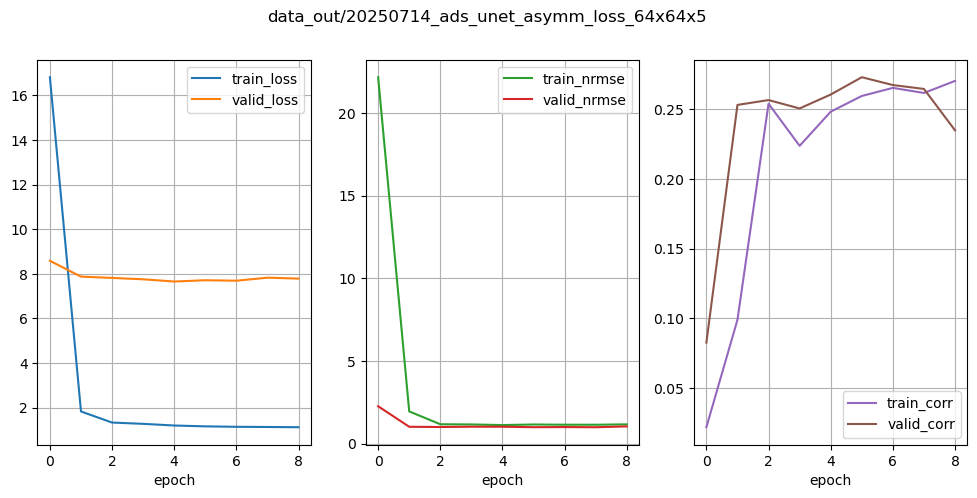

In [22]:
# Plots are easier to read when we ignore the first few epochs
# where the model is just learning the bias
ads_df.plot(
    x="epoch", y=["train_loss", "valid_loss", "train_nrmse", "valid_nrmse", "train_corr", "valid_corr"],
    subplots=[("train_loss", "valid_loss"), ("train_nrmse", "valid_nrmse"), ("train_corr", "valid_corr")],
    layout=(1, 3),
    sharex=True, sharey=False,
    grid=True,
    figsize=(12, 5),
)
plt.gcf().suptitle(ads_trainer.default_root_dir)
plt.show()

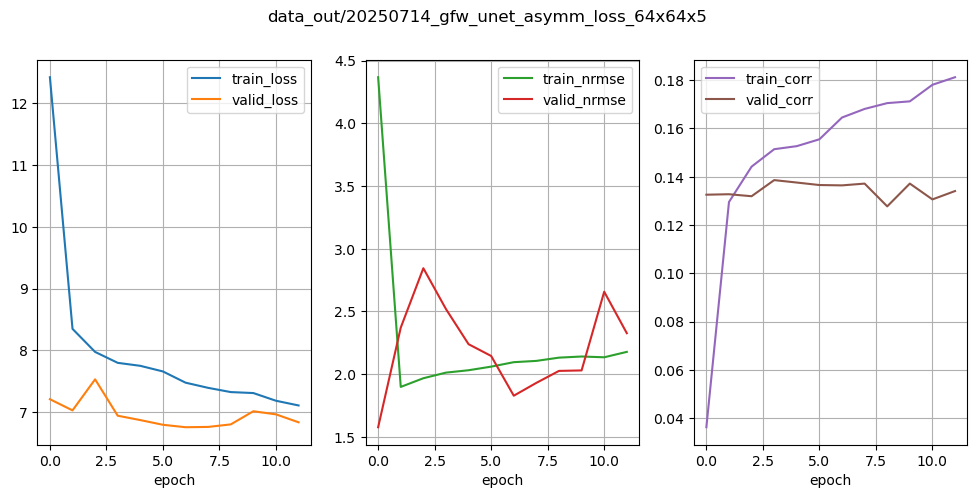

In [23]:
gfw_df.plot(
    x="epoch", y=["train_loss", "valid_loss", "train_nrmse", "valid_nrmse", "train_corr", "valid_corr"],
    subplots=[("train_loss", "valid_loss"), ("train_nrmse", "valid_nrmse"), ("train_corr", "valid_corr")],
    layout=(1, 3),
    sharex=True, sharey=False,
    grid=True,
    figsize=(12, 5),
)
plt.gcf().suptitle(gfw_trainer.default_root_dir)
plt.show()